In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from utils import plot_images, load_embeddings_and_ids

###  Load pre-trained image embeddings

In [2]:
youtube_embeddings,\
artwork_ids,\
artwork_id2index = load_embeddings_and_ids(
'/mnt/workspace/Ugallery/Youtube-like/v1/', 'embeddings.npy', 'ids')

In [3]:
n_artworks = len(artwork_ids)
n_artworks

13297

In [4]:
youtube_embeddings.shape

(13297, 128)

### Build Tensorflow Network Graph for Testing

In [5]:
class Network:
    def __init__(self):
        
        # --- placeholders
        self._precomputed_embeddings = tf.placeholder(shape=[None, 128], dtype=tf.float32)
        self._profile_item_indexes = tf.placeholder(shape=[None], dtype=tf.int32)
        self._candidate_item_indexes = tf.placeholder(shape=[None], dtype=tf.int32)
            
        # ---- user profile vector
        # profile item embeddings average
        tmp = tf.gather(self._precomputed_embeddings, self._profile_item_indexes) 
        self._profile_items_average = tf.reshape(tf.reduce_mean(tmp, axis=0), (1, 128))
        # user hidden layer
        self._user_hidden = tf.layers.dense(
            inputs=self._profile_items_average,
            units=128,
            activation=tf.nn.selu,
            name='user_hidden'
        )
        # user final vector
        self._user_vector = tf.layers.dense(
            inputs=self._user_hidden,
            units=128,
            activation=tf.nn.selu,
            name='user_vector'
        )
        
        # ---- candidate item vectors
        self._candidate_item_vectors = tf.gather(self._precomputed_embeddings, self._candidate_item_indexes)
        
        # ---- match score
        self._match_score = tf.reduce_sum(tf.multiply(self._user_vector, self._candidate_item_vectors), 1)
    
    def get_match_scores(self, sess, precomputed_embeddings, profile_item_indexes, candidate_items_indexes):
        return sess.run(
            self._match_score, feed_dict={
            self._precomputed_embeddings: precomputed_embeddings,
            self._profile_item_indexes: profile_item_indexes,
            self._candidate_item_indexes: candidate_items_indexes,
        })

### Testing Network

In [6]:
MODEL_PATH = '/mnt/workspace/pamessina_models/ugallery/youtube_like/v1/'

In [7]:
image_cache = dict()

In [8]:
all_indexes = list(range(n_artworks))

In [9]:
def get_recommendation(profile_indexes, topk=10):    
    candidate_indexes = set(random.sample(all_indexes, 1000))
    candidate_indexes.update(profile_indexes)
    candidate_indexes = list(candidate_indexes)
    with tf.Graph().as_default():      
        network = Network()  
        with tf.Session() as sess:
            saver = tf.train.Saver()            
            saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH))
            match_scores = network.get_match_scores(sess, youtube_embeddings, profile_indexes, candidate_indexes)
            tuples = [(s,i) for i,s in zip(candidate_indexes, match_scores)]
            tuples.sort(reverse=True)
            return [tuples[i][1] for i in range(topk)]

In [12]:
profile_indexes = random.sample(all_indexes, 4)
profile_ids = [artwork_ids[i] for i in profile_indexes]
rec = get_recommendation(profile_indexes, topk=15)
rec_ids = [artwork_ids[i] for i in rec]
print('profile_indexes = ', profile_indexes)
print('profile_ids = ', profile_ids)
print('recommendation: ', rec_ids)

INFO:tensorflow:Restoring parameters from /mnt/workspace/pamessina_models/ugallery/youtube_like/v1/
profile_indexes =  [4297, 2504, 8253, 10359]
profile_ids =  [28487, 43517, 58654, 54217]
recommendation:  [50138, 52207, 44818, 28487, 54217, 46550, 52527, 37959, 52502, 52529, 51801, 30687, 45726, 43517, 26720]


-------------------------------


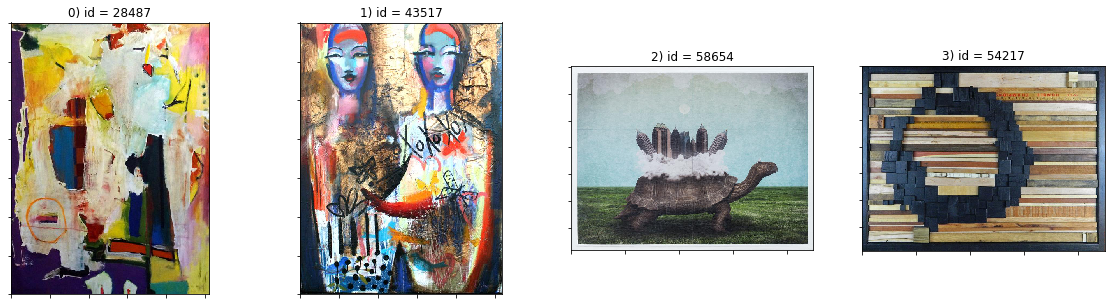

-------------------------------


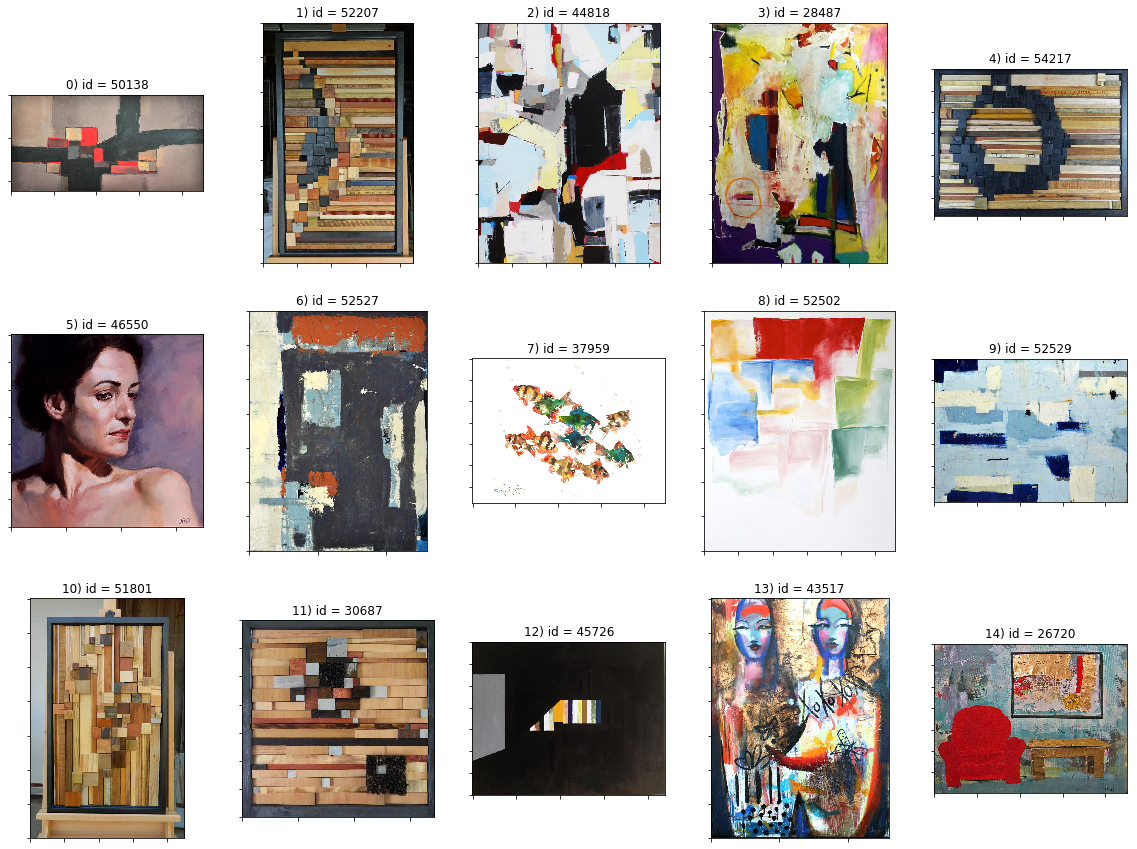

In [13]:
print('-------------------------------')
plot_images(plt, image_cache, profile_ids)
print('-------------------------------')
plot_images(plt, image_cache, rec_ids)